In [0]:
from pydub import AudioSegment
from scipy import signal
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
from librosa import display
import pandas as pd
from sklearn.metrics import confusion_matrix
import keras
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, LSTM, Bidirectional
from keras.optimizers import sgd
import tensorflow as tf
import numpy as np
import itertools
import math
import time

In [1]:
!pip install librosa
!pip install pydub
!pip install pydrive

    100% |████████████████████████████████| 1.6MB 3.0MB/s 
    100% |████████████████████████████████| 327kB 26.7MB/s 
    100% |████████████████████████████████| 3.2MB 10.5MB/s 
    100% |████████████████████████████████| 16.1MB 2.1MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy
    100% |████████████████████████████████| 993kB 19.7MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Definicion de funciones para el calculo del espectro y para mostrar la matriz de confusion

In [0]:
#Compute spectogram of each audio

SR = 22050
def get_short_time_fourier_transform(soundwave):
    return librosa.stft(soundwave, n_fft=256)

def short_time_fourier_transform_amplitude_to_db(stft):
    return librosa.amplitude_to_db(stft)

def soundwave_to_np_spectogram(soundwave):
    step1 = get_short_time_fourier_transform(soundwave)
    step2 = short_time_fourier_transform_amplitude_to_db(step1)
    step3 = step2/100
    return step3

def inspect_data(sound):
#    plt.figure()
#    plt.plot(sound)
#    IPython.display.display(IPython.display.Audio(sound, rate=SR))
    a = get_short_time_fourier_transform(sound)
    Xdb = short_time_fourier_transform_amplitude_to_db(a)
#    plt.figure()   
#    plt.imshow(Xdb)    
#    plt.show()
#    print (Xdb.shape)
#    print("Length per sample: %d, shape of spectogram: %s, max: %f min: %f" % (len(sound), str(Xdb.shape), Xdb.max(), Xdb.min()))
    return Xdb

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Creacion de arrays que contienen la info de audios y participantes en el experimento

In [0]:
#Creacion de las variables necesarias para la ejecucion del codigo

i = 0
j = 0
k = 0
number_list_train = ['']
number_list_test = ['']
file_count = 60
file_count2 = 35
input_array_train = ['']
phq8_array_train = ['']
input_array_train *= file_count
phq8_array_train *= file_count
number_list_train *= file_count
input_array_test = ['']
phq8_array_test = ['']
input_array_test *= file_count2
phq8_array_test *= file_count2
number_list_test *= file_count2

### Segmentacion de los .wav de cada participante, segun el transcript de cada participante


In [0]:
#Abrir archivos de audio y segmentar por segmento de tiempo.
#Exportar los segmentos a otra carpeta para su posterior analisis


number = 0

l = 0
m = 0
      
data = open('C:/Users/Fran/Desktop/Database/datos1.txt', 'r', encoding='utf-8-sig')
for line in data:
    mylist = line.split(',')
    number = mylist[0]
    df = pd.read_csv('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' 
                     + str(number) + '_TRANSCRIPT.csv', header=0)
    while i < len (df):
        a = df.iloc[i].str.split()
        if a[0][2] == 'Participant' and j == 0: 
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav', format="wav")
            j = 1
        elif a[0][2] == 'Participant':
            
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba/' + str(number) + 'segmento.wav', format="wav")
            sound1 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav')
            sound2 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba/' + str(number) + 'segmento.wav')

            combined_sounds = sound1 + sound2
            combined_sounds.export('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav', format="wav")
        i += 1
             
    w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    input_array_train[l] = w
    number_list_train[l] = number
    phq8_array_train[l] = mylist[1]
    l += 1
    j = 0
    i = 0
    


In [0]:
#Abrir archivos de audio y segmentar por segmento de tiempo.
#Exportar los segmentos a otra carpeta para su posterior analisis

i = 0
l = 0
m = 0
data1 = open('C:/Users/Fran/Desktop/Database/datos2_dev.txt', 'r', encoding='utf-8-sig')
for line in data1:
    mylist = line.split(',')
    number = mylist[0]
    df = pd.read_csv('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' 
                     + str(number) + '_TRANSCRIPT.csv', header=0)
    while i < len (df):
        a = df.iloc[i].str.split()
        if a[0][2] == 'Participant' and j == 0: 
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav', format="wav")
            j = 1
        elif a[0][2] == 'Participant':
            
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + 'segmento.wav', format="wav")
            sound1 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav')
            sound2 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba_test/' + str(number) + 'segmento.wav')

            combined_sounds = sound1 + sound2
            combined_sounds.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav', format="wav")
        i += 1
             
    w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    input_array_test[l] = w
    number_list_test[l] = number
    phq8_array_test[l] = mylist[1]
    l += 1
    j = 0
    i = 0 

### Completo los arrays creados anteriormente con la informacion necesaria

In [0]:
#creacion de arrays, que seran usados despues para el entranamiento del modelo y creacion de espectogramas

l = 0
data = open('/content/drive/My Drive/datos1_prueba.txt', 'r', encoding='utf-8-sig')
for line in data:
    mylist = line.split(',')
    number = mylist[0]
    #w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    #input_array_train[l] = w
    number_list_train[l] = number
    phq8_array_train[l] = mylist[1]
    l += 1
    
l = 0
data1 = open('/content/drive/My Drive/datos2_dev.txt', 'r', encoding='utf-8-sig')
for line in data1:
    mylist = line.split(',')
    number = mylist[0]
    #w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    #input_array_test[l] = w
    number_list_test[l] = number
    phq8_array_test[l] = mylist[1]
    l += 1

In [0]:
#Calculo de la longitud de cada audio para en un futuro poder mover la ventana de tiempo 
#del minimo al maximo unos determinados segundos, de momento esta informacion no se utiliza
#y se calcula el segmento de audio con un tiempo fijo

len_list_train = ['']
len_list_test = ['']
len_list_train *= file_count
len_list_test *= file_count2
i = 0
j = 0


for audio_number in number_list_train:
    Audio_train = AudioSegment.from_wav('/content/drive/My Drive/prueba/' + str(audio_number) + '.wav')
    len_list_train[i] = int(len(Audio_train) / (1000))
    i += 1
    
    
for audio_number in number_list_test:
    Audio_test = AudioSegment.from_wav('/content/drive/My Drive/prueba_test/' + str(audio_number) + '.wav')
    len_list_test[j] = int(len(Audio_test) / (1000))
    j += 1
    


### Data Augmentation para crear mas muestras por cada participante, se amplia el numeor d emuestras y su valor objetivo a predecir despues por el modelo

In [9]:
#Creacion de los segmentos de audio para despues crear los espectogramas
#data augmentation segun el valor de la comparacion con la variable i de cada bucle while

t1_train_ini = 5 * 1000
t1_test_ini = 5 * 1000
t2_train_end = 8 * 1000
t2_test_end = 8 * 1000
i = 0
for audio_number in number_list_train:  
    i = 0
    while i<10:
        Audio_train = AudioSegment.from_wav('/content/drive/My Drive/prueba/' + str(audio_number) + '.wav')
        t1_train_ini_ = t1_train_ini + ((i*3)+(i))*1000
        t2_train_end_ = t2_train_end + ((i*3)+(i))*1000
        Audio_train = Audio_train[t1_train_ini_:t2_train_end_]
        Audio_train.export('/content/drive/My Drive/database_train/' + str(audio_number) + '_' + str(i) + '.wav', format="wav")
        i += 1
        time.sleep(1)

t1_train_ini = 5 * 1000
t1_test_ini = 5 * 1000
t2_train_end = 8 * 1000
t2_test_end = 8 * 1000
i = 0   
for audio_number in number_list_test:
    i = 0
    while i<10:
        Audio_test = AudioSegment.from_wav('/content/drive/My Drive/prueba_test/' + str(audio_number) + '.wav')
        t1_train_ini_ = t1_train_ini + ((i*3)+(i))*1000
        t2_train_end_ = t2_train_end + ((i*3)+(i))*1000
        Audio_test = Audio_test[t1_train_ini_:t2_train_end_]
        Audio_test.export('/content/drive/My Drive/database_test/' + str(audio_number) + '_' + str(i) + '.wav', format="wav")
        time.sleep(1)
        i += 1

KeyboardInterrupt: ignored

In [0]:
#data augmentation para el valor a predecir

multiplier = 10
phq8_array_train_extended = np.ndarray(shape = (60*multiplier,1))
phq8_array_test_extended = np.ndarray(shape = (35*multiplier,1))
i = 0
j = 0
for valor in phq8_array_train:
    while i < multiplier:
        phq8_array_train_extended[j] = valor
        i += 1
        j += 1
    i = 0

i = 0
j = 0
for valor in phq8_array_test:
    while i < multiplier:
        phq8_array_test_extended[j] = valor
        i += 1
        j += 1
    i = 0

### Creacion de los espectogramas de cada segmento de audio

In [11]:
#Spectograms of each segmented audio


Xdb_train = ['']
Xdb_train_normalized = ['']
Xdb_train *= file_count
Xdb_train_normalized *= file_count

Xdb_train *= 10

Xdb_test = ['']
Xdb_test_normalized = ['']
Xdb_test *= file_count2
Xdb_test_normalized *= file_count2

Xdb_test *= 10

i = 0
j = 0
for audio_train in number_list_train:
    j = 0
    while j<10:
        X, sr = librosa.load('/content/drive/My Drive/database_train_0.3/' + str(audio_train) + '_' + str(j) + '.wav')
        Xdb_train[i] = abs(soundwave_to_np_spectogram(X))
        #Xdb_train_normalized[i] = tf.log(tf.abs(Xdb_train[i]) + 0.01)
        i += 1
        j += 1

i = 0
j = 0
for audio_test in number_list_test:
    j = 0
    while j<10:
        X, sr = librosa.load('/content/drive/My Drive/database_test_0.3/' + str(audio_test) + '_' + str(j) + '.wav')
        Xdb_test[i] = abs(soundwave_to_np_spectogram(X))
        #Xdb_test_normalized[i] = tf.log(tf.abs(Xdb_test[i]) + 0.01)
        i += 1
        j += 1

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [0]:
# coger el tamaño del espectograma para usarlo mas adelante

alto, ancho = np.shape(Xdb_train[0])

In [0]:
Xdb_train[3]

array([[0.21856171, 0.16251087, 0.40459198, ..., 0.12605885, 0.18477058,
        0.17381203],
       [0.09134532, 0.08068188, 0.07643799, ..., 0.08864266, 0.07603037,
        0.10474082],
       [0.1192214 , 0.05682746, 0.0747643 , ..., 0.09268442, 0.03922263,
        0.06402485],
       ...,
       [0.67581666, 0.73601675, 0.83922267, ..., 0.83922267, 0.83922267,
        0.83922267],
       [0.67587996, 0.7360913 , 0.83922267, ..., 0.83922267, 0.83922267,
        0.83922267],
       [0.6759087 , 0.7361429 , 0.83922267, ..., 0.83922267, 0.83922267,
        0.83922267]], dtype=float32)

In [0]:
X, sr = librosa.load('/content/drive/My Drive/database_train/' + '303' + '_' + '0' + '.wav')
prueba = soundwave_to_np_spectogram(X)

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


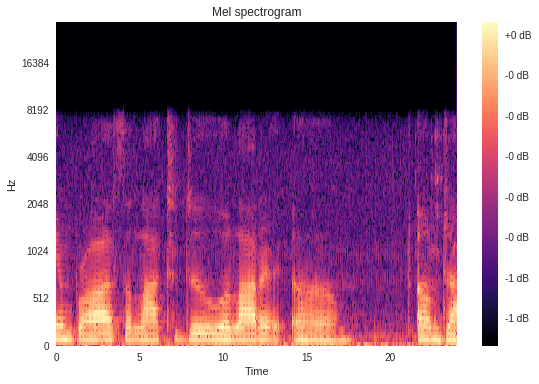

In [0]:
librosa.display.specshow(prueba,
                         y_axis='mel', fmax=30000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [12]:
#Espectograma de 1 audio segmentado

plt.imshow(Xdb_train_array[10])
plt.show()


NameError: ignored

In [0]:
np.shape(Xdb_train)

(600, 129, 1034)

In [0]:
np.shape(Xdb_train_array)

(600, 95, 104)

### Adaptacion de los datos de entrada segun sean para una red convolucional o para una red LSTM

In [0]:
#Creacion de los arrays, transformand el array para introducirlo en la red convolucional
multiplier = 10
Xdb_train_array = np.ndarray(shape = (60*multiplier,95,ancho))
Xdb_test_array = np.ndarray(shape = (35*multiplier,95,ancho))

i = 0
for train in Xdb_train:
    Xdb_train_array[i] = train[0:95,:]
    i += 1
    
i = 0
for test in Xdb_test:
    Xdb_test_array[i] = test[0:95,:]
    i += 1
    
Xdb_train_array = Xdb_train_array.reshape(600,95, ancho, 1)
Xdb_test_array = Xdb_test_array.reshape(350,95, ancho, 1)

In [0]:
#Creacion de los arrays, transformand el array para introducirlo en la red LSTM

Xdb_train_array_lstm = np.ndarray(shape = (60*multiplier,95,ancho))
Xdb_test_array_lstm = np.ndarray(shape = (35*multiplier,95,ancho))

i = 0
for train in Xdb_train:
    Xdb_train_array_lstm[i] = train[0:95,:]
    i += 1
    
i = 0
for test in Xdb_test:
    Xdb_test_array_lstm[i] = test[0:95,:]
    i += 1
    
Xdb_train_array_lstm = Xdb_train_array_lstm.reshape(60*multiplier ,95*ancho)
Xdb_test_array_lstm = Xdb_test_array_lstm.reshape(35*multiplier, 95*ancho)

Xdb_train_array_lstm = np.reshape(Xdb_train_array_lstm, (Xdb_train_array_lstm.shape[0], 1, Xdb_train_array_lstm.shape[1]))
Xdb_test_array_lstm = np.reshape(Xdb_test_array_lstm, (Xdb_test_array_lstm.shape[0], 1, Xdb_test_array_lstm.shape[1]))

### Pruebas varias, actualmente en desuso

In [0]:
#i= 0
#for audio_train in number_list_train:
#    Xdb_train[i] = Xdb_train[i].reshape(1333344,)
#    i += 1
    
#i= 0    
#for audio_test in number_list_test:
#    Xdb_test[i] = Xdb_test[i].reshape(1333344,)
#    i += 1
phq8_array_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [0]:
#Xdb_train_array=Xdb_train_array.reshape(Xdb_train_array.shape[0],Xdb_train_array.shape[1],1)

In [0]:
#Xdb_test_array=Xdb_test_array.reshape(Xdb_test_array.shape[0],Xdb_test_array.shape[1],1)

In [0]:
#np.shape(Xdb_train_array)

In [0]:
#num_classes = 2
#batch_size = 64
#epochs = 10

In [0]:
#Xdb_train_array = Xdb_train_array.reshape(Xdb_train_array.shape[0], alto, ancho, 1)
#Xdb_test_array = Xdb_test_array.reshape(Xdb_test_array.shape[0], alto, ancho, 1)

In [0]:
#seq = Sequential()
#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   input_shape=(107, 129, 1723, 1),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

#seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
#               activation='sigmoid',
#               padding='same', data_format='channels_last'))
#seq.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [0]:
#print (Xdb_train_array.shape)
#print (Xdb_test_array.shape)
phq8_array_train_extended

NameError: ignored

### Creacion de los modelos de red neuronal, LSTM y convolucional

In [0]:
num_classes = 2
batch_size = 64
epochs = 10

# convert class vectors to binary class matrices
phq8_array_train = keras.utils.to_categorical(phq8_array_train_extended, num_classes)
phq8_array_test = keras.utils.to_categorical(phq8_array_test_extended, num_classes)

In [23]:
#Red neuronal

model = Sequential()
model.add(Conv2D(80, kernel_size=(3, 3), activation='relu', input_shape=(95,ancho,1)))
model.add(MaxPooling2D(pool_size=(4, 3)))
model.add(Conv2D(80, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 3)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 93, 102, 80)       800       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 34, 80)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 32, 80)        57680     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 10, 80)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               4301056   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
__________

In [24]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(128, return_sequences=True),
                        input_shape=(1, 95*ancho)))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(num_classes, activation='softmax'))

model1.summary()
model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(),
              metrics=['accuracy'])
#categorical_crossentropy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 1, 256)            10249216  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 130       
Total params: 10,421,954
Trainable params: 10,421,954
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True,
               input_shape=(1, alto*ancho))))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(32, return_sequences=True)))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(32)))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.summary
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
np.shape(phq8_array_train)

(600, 2)

In [0]:
phq8_array_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Entrenamiento del sistema

In [25]:
model.fit(Xdb_train_array, phq8_array_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(Xdb_test_array, phq8_array_test))
score = model.evaluate(Xdb_test_array, phq8_array_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 600 samples, validate on 350 samples
Epoch 1/10
600/600 [==============================] - 18s 30ms/step - loss: 0.7030 - acc: 0.4850 - val_loss: 0.6900 - val_acc: 0.6571
Epoch 2/10
600/600 [==============================] - 16s 27ms/step - loss: 0.6949 - acc: 0.4900 - val_loss: 0.7117 - val_acc: 0.3429
Epoch 3/10
600/600 [==============================] - 16s 26ms/step - loss: 0.6942 - acc: 0.5000 - val_loss: 0.7002 - val_acc: 0.3429
Epoch 4/10
600/600 [==============================] - 16s 26ms/step - loss: 0.6976 - acc: 0.4900 - val_loss: 0.6971 - val_acc: 0.3429
Epoch 5/10
600/600 [==============================] - 16s 27ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6946 - val_acc: 0.3429
Epoch 6/10
600/600 [==============================] - 16s 26ms/step - loss: 0.6928 - acc: 0.5100 - val_loss: 0.6857 - val_acc: 0.6571
Epoch 7/10
600/600 [==============================] - 16s 27ms/step - loss: 0.6951 - acc: 0.4767 - val_loss: 0.6927 - val_acc: 0.6457
Epoch 8/10
600/6

In [28]:
model1.fit(Xdb_train_array_lstm, phq8_array_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(Xdb_test_array_lstm, phq8_array_test))
score = model1.evaluate(Xdb_test_array_lstm, phq8_array_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 600 samples, validate on 350 samples
Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 0.6954 - acc: 0.4867 - val_loss: 0.6997 - val_acc: 0.3429
Epoch 2/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6923 - acc: 0.5100 - val_loss: 0.6916 - val_acc: 0.6571
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6940 - acc: 0.5200 - val_loss: 0.6913 - val_acc: 0.6571
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6951 - acc: 0.4917 - val_loss: 0.6973 - val_acc: 0.3429
Epoch 5/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6964 - acc: 0.4583 - val_loss: 0.6983 - val_acc: 0.3429
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6946 - acc: 0.4967 - val_loss: 0.6917 - val_acc: 0.6571
Epoch 7/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6937 - acc: 0.5083 - val_loss: 0.6876 - val_acc: 0.6571
Epoch 8/10
600/600 [==========

In [0]:
prediccion = model.predict(Xdb_test_array, batch_size=batch_size, verbose=1, steps=None)
for i in prediccion:
    print('Valor predicho:', i)

### Matriz de confusion

In [0]:
conf_matrix_pred = ['']
conf_matrix_pred *= 35
j = 0
for i in prediccion:
    conf_matrix_pred[j] = i.argmax(axis=0)
    print ("Clase: " + str(i.argmax(axis=0)))
    j += 1

Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0


In [0]:
conf_matrix_test = ['']
conf_matrix_test *= 35
j = 0
for i in phq8_array_test:
    conf_matrix_test[j] = i.argmax(axis=0)
    print ("Clase: " + str(i.argmax(axis=0)))
    j += 1

Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 1
Clase: 1
Clase: 1
Clase: 1
Clase: 0
Clase: 1
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 1
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0


In [0]:
cnf_matrix = confusion_matrix(conf_matrix_test,conf_matrix_pred)

Confusion matrix, without normalization
[[23  0]
 [12  0]]


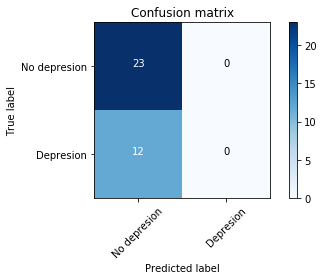

In [0]:
plot_confusion_matrix(cnf_matrix, classes=['No depresion','Depresion'],
                      title='Confusion matrix')